In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

from imports import *
from loading import load_session_data
import numpy as np
import h5py, json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
import pandas as pd
from session.sessions import selected_009266, selected_009265

%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [19]:
session = sessions[11]

In [20]:
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009265_hippoSIT_2023-03-03_09-37-07'

## Overview

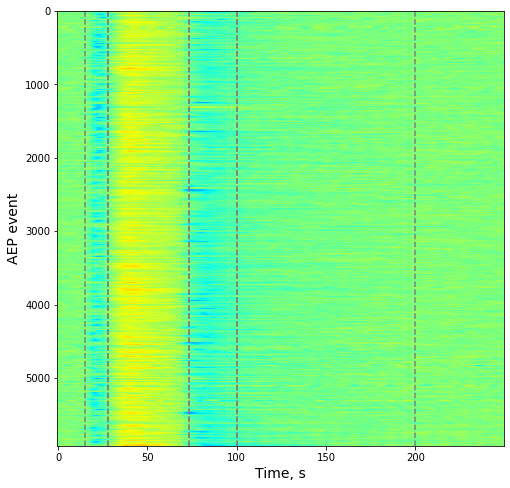

In [21]:
# AEPs profiles
area = 'A1'

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(aeps[area], aspect='auto', cmap='jet')
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('AEP event', fontsize=14)
for key, value in AEP_metrics_lims[area].items():
    ax.axvline(value[0], color='gray', ls='--')
    ax.axvline(value[1], color='gray', ls='--')

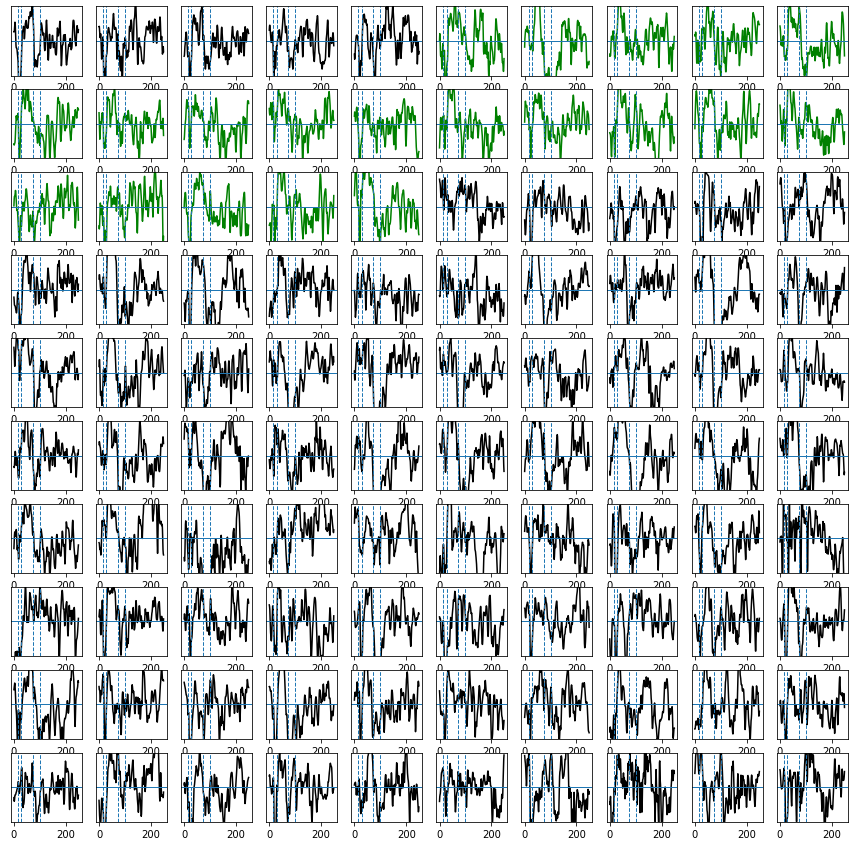

In [22]:
#look at 100 AEPs
fig = plt.figure(figsize=(15, 15))

#idx_l, idx_r = 1430, 1480
idx_l, idx_r = 1200, 1300
selected = aeps[area][idx_l:idx_r]
#selected = aeps[aeps_bgr_b_idxs + 1]

for i, aep in enumerate(selected):
    color = 'green' if aeps_events[idx_l + i][1] == 2 else 'black'
    
    ax = fig.add_subplot(10, 10, i+1)
    ax.plot(aep, color=color)
    ax.axhline(0, lw=1)
    for x_coord in [x[0] for x in AEP_metrics_lims[area].values()]:
        ax.axvline(x_coord, lw=1, ls='--')
    ax.set_ylim(-1500, 1500)
    ax.set_yticks([])

## AEP metrics relative BGR / TGT start

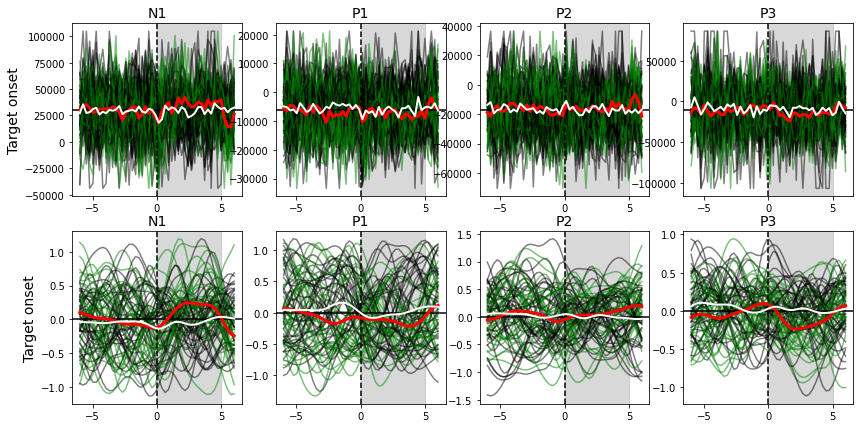

In [23]:
fig = plt.figure(figsize=(14, 7))

t_lag  = 6  # seconds
tgt_starts = []
labels = ['Target onset', 'Background onset']
dim = len(AEP_metrics_lims[area])
times = np.linspace(-6, 6, 48)
tgt_dur = cfg['experiment']['target_duration']

for i, metric_type in enumerate([AEP_metrics_raw[area], AEP_metrics_norm[area]]):
    for j, (m_name, metric) in enumerate(metric_type.items()):
        ax = fig.add_subplot(2, dim, i*dim + j + 1)
        means_succ = []
        means_miss = []

        for idx_aep, result in tgt_matrix[:, (2, 4)]:  # iterate over all tgt entrances / exits
            if idx_aep < 24 or idx_aep > len(aeps_events) - 24:
                continue
            clr = 'green' if result == 1 else 'black'
            ev_idxs = np.arange(idx_aep - 24, idx_aep + 24)  # +- 6 secs
            ax.plot(times, metric[ev_idxs], color=clr, alpha=0.5)
            if result == 1:
                means_succ.append(metric[ev_idxs])
            else:
                means_miss.append(metric[ev_idxs])

        # plot means
        ax.axvline(0, ls='--', color='black')
        ax.axhline(metric.mean(), color='black')
        ax.plot(times, np.array(means_succ).mean(axis=0), color='red', lw=3)
        ax.plot(times, np.array(means_miss).mean(axis=0), color='white', lw=2)
        ax.set_title(m_name, fontsize=14)
        ax.axvspan(0, tgt_dur, alpha=0.3, color='gray')
        if j == 0:
            ax.set_ylabel(labels[j], fontsize=14)
            
#fig.tight_layout()
fig.savefig(os.path.join(report_path, 'AEP_metrics_tgt_onset.pdf'))

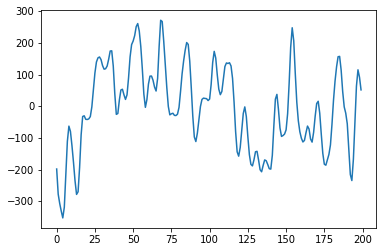

In [100]:
tgt_succ = tgt_matrix[tgt_matrix[:, 4] == 1]
plt.plot(aeps[tgt_succ[:, 2][:-2] + 20].mean(axis=0))

## AEPs timeline

In [143]:
unit_id = '6-6'

with h5py.File(h5name, 'r') as f:
    i_rate = np.array(f['units'][str(unit_id)]['inst_rate'])
    s_times = np.array(f['units'][str(unit_id)]['spike_times'])

(150.0, 225.0)

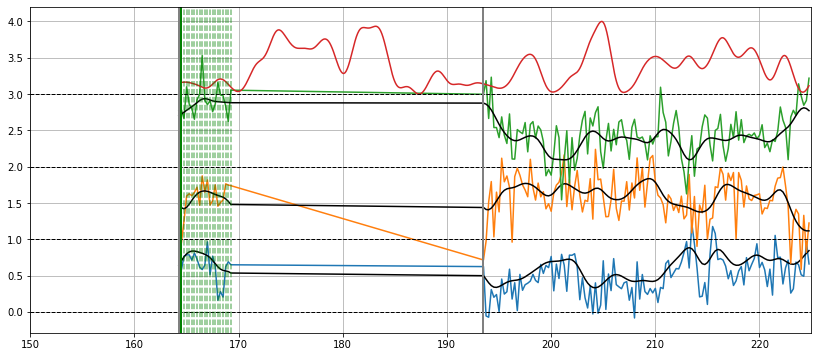

In [144]:
t_start, t_end = 150, 225  # secs

fig = plt.figure(figsize=(14, 6))

# mins in the N1 range
ax = fig.add_subplot(1, 1, 1)
ev_idxs  = np.where((aeps_events[:, 0] > t_start) & (aeps_events[:, 0] < t_end))[0]

normed   = [N1_norm, P1_norm, N2_norm]
smoothed = [N1_smooth_norm, P1_smooth_norm, N2_smooth_norm]
ratios   = [N1_ratio, P1_ratio, N2_ratio]

for i in range(3):  # AEP N1, P1, N2 metrics
    norm = normed[i]
    vals = ratios[i] * (norm[ev_idxs] - norm[ev_idxs].mean()) + norm[ev_idxs].mean()
    ax.plot(aeps_events[ev_idxs][:, 0], i + vals)
    ax.plot(aeps_events[ev_idxs][:, 0], i + smoothed[i][ev_idxs], color='black')
    #ax.axhline(i + smoothed[i].mean(), lw=1, ls='--', color='black')
    ax.axhline(i, lw=1, ls='--', color='black')

# selected unit firing rate
idxs_tl = np.where((tl[:, 0] > aeps_events[ev_idxs[0]][0]) & (tl[:, 0] < aeps_events[ev_idxs[-1]][0]))[0]
ax.plot(tl[idxs_tl][:, 0], 3 + to_normed(i_rate[idxs_tl]))
ax.grid()
ax.axhline(3, lw=1, ls='--', color='black')

sel_events = aeps_events[ev_idxs]
tgt_events = sel_events[sel_events[:, 1] == 2]
for t_event in tgt_events[:, 0]:
    ax.axvline(t_event, color='green', ls='--', alpha=0.5)
for t_event in tl[idxs_tgt_start][:, 0]:
    ax.axvline(t_event, color='green', lw=2)
for t_event in tl[idxs_bgr_start][:, 0]:
    ax.axvline(t_event, color='gray', lw=2)  
ax.set_xlim(t_start, t_end)